<a href="https://colab.research.google.com/github/IsaacFigNewton/Taxonomic-Span-Categorization/blob/main/HDBSCAN_for_ATC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Config

In [1]:
!pip install hdbscan

In [2]:
import random
import spacy
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
import nltk
from nltk.corpus import gutenberg
import hdbscan

nltk.download("gutenberg")

/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


True

# Helpers

In [44]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723
    Licensed under Creative Commons Attribution-Share Alike

    If the graph is a tree this will return the positions to plot this in a
    hierarchical layout.

    G: the graph (must be a tree)

    root: the root node of current branch
    - if the tree is directed and this is not given,
      the root will be found and used
    - if the tree is directed and this is given, then
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given,
      then a random choice will be used.

    width: horizontal space allocated for this branch - avoids overlap with other branches

    vert_gap: gap between levels of hierarchy

    vert_loc: vertical location of root

    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''

        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)
        if len(children)!=0:
            pos = _hierarchy_pos(
                G,
                children[0],
                width = width,
                vert_gap = vert_gap,
                vert_loc = vert_loc-vert_gap,
                xcenter=0,
                pos=pos,
                parent = root
            )
            pos = _hierarchy_pos(
                G,
                children[1],
                width = width,
                vert_gap = vert_gap,
                vert_loc = vert_loc-vert_gap,
                xcenter=10,
                pos=pos,
                parent = root
            )
        return pos


    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [22]:
def dendrogram_to_graph(Z, embeddings, labels, max_depth=10):
    """
    Convert a dendrogram linkage matrix into a NetworkX graph.
    Each node stores its centroid as metadata.

    Args:
        Z: linkage matrix
        embeddings: original embeddings
        labels: labels for leaf nodes
        max_depth: (int or None) maximum depth of hierarchy to expand
                   depth=0 means only root, depth=1 adds its children, etc.
    """
    G = nx.DiGraph()
    n_samples = len(embeddings)

    # Add leaf nodes
    for i, (label, emb) in enumerate(zip(labels, embeddings)):
        G.add_node(i, label=label, centroid=emb.tolist())

    # Internal nodes
    for i, (c1, c2, dist, sample_count) in enumerate(Z):
        node_id = n_samples + i
        c1, c2 = int(c1), int(c2)

        members = [np.array(G.nodes[c]["centroid"]) for c in (c1, c2)]
        centroid = np.mean(members, axis=0)

        G.add_node(node_id, centroid=centroid.tolist(), size=sample_count)
        G.add_edge(node_id, c1, weight=dist)
        G.add_edge(node_id, c2, weight=dist)

    return G


def assign_nearest_words(G, df):
    word_embeddings = df.values
    words = df.index.tolist()

    for node, data in G.nodes(data=True):
        centroid = np.array(data["centroid"]).reshape(1, -1)
        sims = euclidean_distances(centroid, word_embeddings)[0]
        best_idx = np.argmax(sims)
        best_word = words[best_idx]
        G.nodes[node]["nearest_word"] = best_word
    return G


def draw_taxonomy(G, max_depth=5):
    """
    Plot the first `max_level` levels of a taxonomy graph G.

    Args:
        G: NetworkX DiGraph with nodes containing 'nearest_word'
        max_level: how many levels to plot starting from the root
    """
    # Find root(s) — nodes with no parents
    root = next(iter(nx.topological_sort(G)))

    # Collect nodes to draw based on level
    nodes_to_draw = set()
    def add_level(node, current_level):
        if current_level > max_depth:
            return
        nodes_to_draw.add(node)
        for child in G.successors(node):
            add_level(child, current_level + 1)
    add_level(root, 0)

    # Draw subgraph
    subG = G.subgraph(nodes_to_draw)
    pos = hierarchy_pos(subG, root)
    labels = {n: G.nodes[n].get("nearest_word", str(n)) for n in subG.nodes()}

    plt.figure(figsize=(12, 8))
    nx.draw(subG, pos, with_labels=True, labels=labels, node_size=500, node_color="lightblue", font_size=10)
    plt.title(f"Taxonomy - First {max_depth} Levels")
    plt.show()


In [23]:
class TaxonomyPipeline:
    def __init__(self, model_name="all-MiniLM-L6-v2", hdbscan_params=None):
        self.nlp = spacy.load("en_core_web_sm")
        self.embedder = SentenceTransformer(model_name)
        # allow user to tune HDBSCAN (e.g. min_cluster_size, metric, cluster_selection_method, etc.)
        self.hdbscan_params = hdbscan_params or {"min_cluster_size": 5}

    def process(self, text_or_texts):
        """
        Process a single string OR a list of plaintext corpora.
        Returns the graph after building taxonomy.

        Uses HDBSCAN to obtain the single-linkage tree (SciPy linkage format)
        via clusterer.single_linkage_tree_.to_numpy() and passes that to
        dendrogram_to_graph(...) so the rest of your pipeline is unchanged.
        """
        # Normalize input to list
        if isinstance(text_or_texts, str):
            corpora = [text_or_texts]
        elif isinstance(text_or_texts, list):
            corpora = text_or_texts
        else:
            raise TypeError("Input must be a string or list of strings.")

        # Step 1: Extract noun chunks from all corpora
        noun_chunks = []
        for text in corpora:
            doc = self.nlp(text)
            noun_chunks.extend([chunk.text.strip() for chunk in doc.noun_chunks])

        if len(noun_chunks) == 0:
            # handle empty case gracefully
            return None

        # Step 2: Get embeddings
        embeddings = self.embedder.encode(noun_chunks)

        # Step 3: Build dataframe (all noun chunks pooled)
        df = pd.DataFrame(embeddings, index=noun_chunks)

        # Step 4: Normalize
        pipeline = Pipeline([("scaler", StandardScaler())])
        normalized_embeddings = pipeline.fit_transform(embeddings)

        # Step 5: Clustering with HDBSCAN and extract single-linkage tree (SciPy linkage)
        # Note: the hdbscan implementation builds a single-linkage tree internally;
        # the SingleLinkageTree object exposes a .to_numpy() that returns a SciPy-style linkage.
        clusterer = hdbscan.HDBSCAN(**self.hdbscan_params)
        clusterer.fit(normalized_embeddings)

        try:
            # SingleLinkageTree.to_numpy() returns SciPy-style linkage (n_samples-1, 4)
            Z = clusterer.single_linkage_tree_.to_numpy()
        except Exception as e:
            # If something unexpected happens, give a helpful error
            raise RuntimeError(
                "Unable to extract single-linkage tree from HDBSCAN. "
                "Make sure you have a recent 'hdbscan' installed. "
                f"Underlying error: {e}"
            )

        # Step 6: Build graph (re-using your existing conversion)
        G = dendrogram_to_graph(Z, embeddings, noun_chunks)

        # Step 7: Assign nearest words
        G = assign_nearest_words(G, df)

        return G

# Test

In [18]:
files = gutenberg.fileids()
corpora = [gutenberg.raw(fid)[:2000] for fid in files]

pipeline = TaxonomyPipeline()
G = pipeline.process(corpora)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


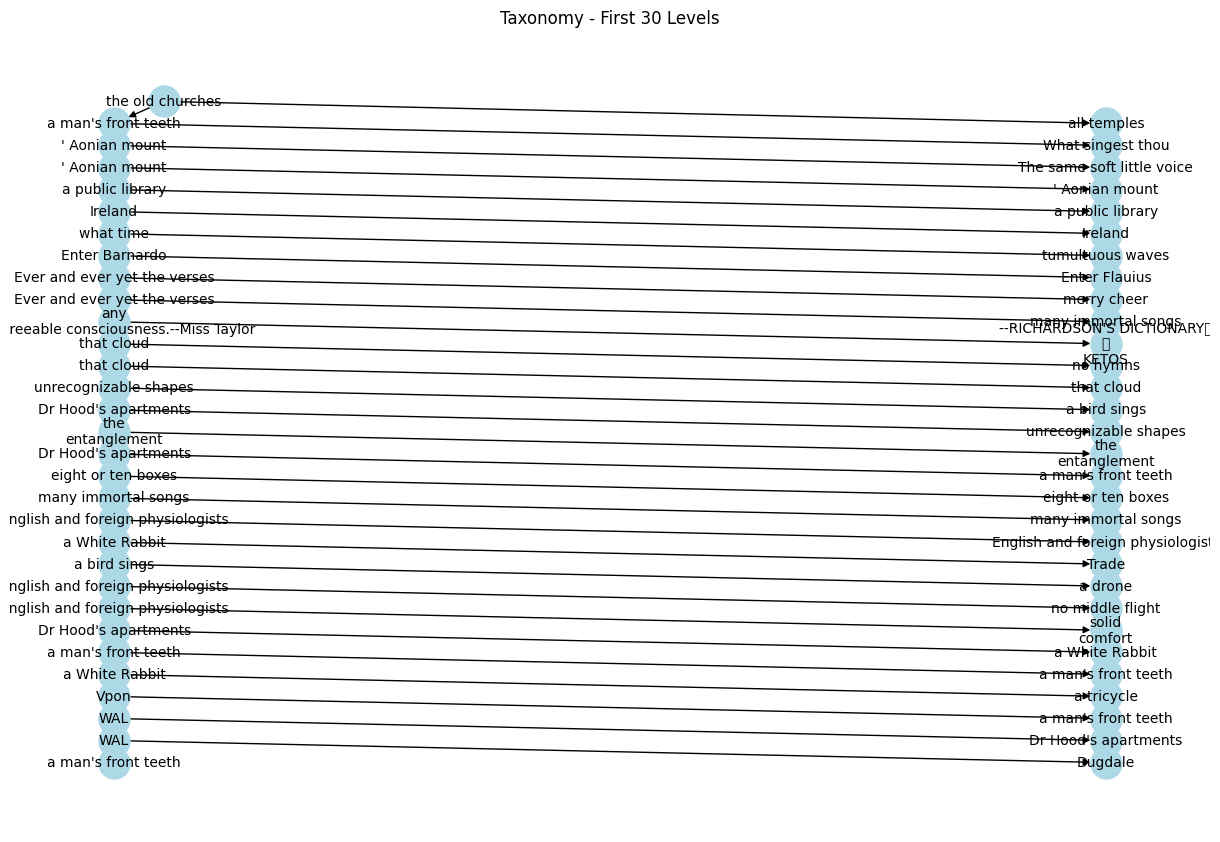

In [47]:
draw_taxonomy(G, max_depth=30)